# Plot model outside of calibration region

In [1]:
#!/usr/bin/env python3

# Setup the notebook's environment
import lalsimulation as lalsim
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"


In [120]:
print(eta2m1m2(0.04))

(0.9582575694955839, 0.041742430504416)


(notebook)>> Loading parameter space data.
(notebook)>> Saving batch plot to /Users/book/KOALA/PhenomXCP/data/version2/waveform_extrapolation_diagnostic_l2m2.pdf
(notebook)>> Done.


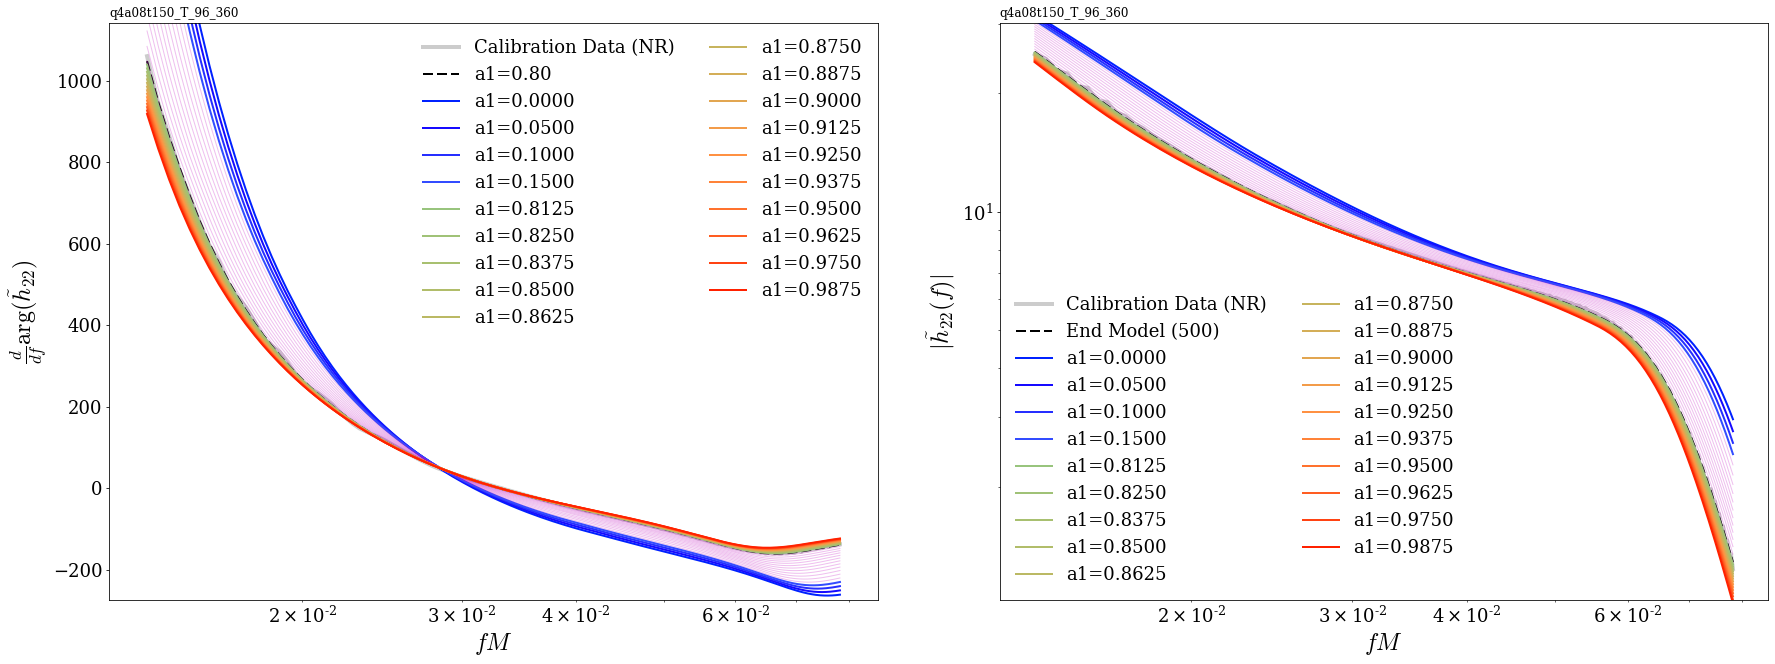

In [118]:

#
ll = 2

# --------------------------------------- #
# Preliminaries
# --------------------------------------- #

#
alert('Loading parameter space data.')

# Define data location
package_dir = parent( xcp.__path__[0] )
datadir = package_dir + 'data/version2/'
files = glob( datadir+'*_l%im%i.txt'%(ll,ll) )
files.sort()
# files = files[::-1]#

file_map = []
for j,sn_ in enumerate(metadata_dict['simname']):

    # Find index location of this metadata in the list of file paths
    k = [ k for k,val in enumerate(files) if sn_ in val ][0]

    # 
    file_map.append(k)

# Sort file paths like matadata so that we can then sort both according to distance between physical parameters
files = array(files)[file_map]
    
reference_index = 0
# theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z
mask = [0,3,9] # theta, eta, a1 -- the parameters that will be used to calculate distance for sorting
coordinates = metadata_dict['array_data'][:,mask]
coordinates[:,0] = cos(coordinates[:,0]) # use cos theta 
index_map, sorted_coordinates = distance_sort( coordinates, reference_index, center=not False )

#
files = list(files[index_map]) 

# Load and unpack physical parameter space
# NOTE that the order of these parameters must be the same as that in files
opt_parameter_range = loadtxt(datadir+'fit_opt_parameters.txt')
scarecrow = template_amp_phase(0.5, 0.5,zeros(3),zeros(3),ell=2)
parameter_names_in_order = scarecrow.__code__.co_varnames[1:scarecrow.__code__.co_argcount]
model_range = {  parameter_names_in_order[k]:var for k,var in enumerate(opt_parameter_range.T) }

#
fig,ax = subplots( len(files), 2, figsize=3*array([ 2.5*2/(0.618), 1.5*2*len(files) ]) )
# fig,ax = subplots( 1, 2, figsize=3*array([ 2.5*2/(0.618), 1.5*2 ]) )
# fig,ax = subplots( len(files), 2, figsize=3*array([ 2.5*2/(0.618), 1.5*len(files) ]) )
ax = ax.flatten()

#
tight_layout(w_pad=4,h_pad=4)

#
foo = {}

#
lmlist = [ (ll,ll) ]

#
p = 0
for j,f_ in enumerate(files):

    #
    simname = f_.split('/')[-1].split('_l%im%i.'%(ll,ll))[0]
    
    if True: # 'q4a08t150' in simname:

        #
        simname = f_.split('/')[-1].split('_l%im%i.'%(ll,ll))[0]

        # Find index location of metadata for simname 
        k = [ k for k,val in enumerate(metadata_dict['simname']) if val in simname ][0]

        # Load data for this case
        raw_data = loadtxt(f_).T
        calibration_data, dphi_lorentzian_min, f_min, f_max, f_lorentzian_min = determine_data_fitting_region( raw_data )

        # Collect params for this case 
        metadata = metadata_dict['array_data'][k,:]

        #
        f,amp_fd,dphi_fd,alpha,beta,gamma = calibration_data.T
        theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z = metadata_dict['array_data'][k]
        chi1_vec = array([chi1_x,chi1_y,chi1_z])
        chi2_vec = array([chi2_x,chi2_y,chi2_z])
        #dphi_fd -= min( dphi_fd[ (f>0.03)&(f<0.12) ] )
        dphi_fd -= mean( dphi_fd )

        #
        action_helper = template_amp_phase(m1, m2, chi1_vec, chi2_vec,ell=2)
        mod_xhm0_amp,mod_xhm0_dphi = action_helper(f)

        #
        popt = opt_parameter_range[j,:]
        opt_amp,opt_dphi = action_helper(f,*popt)

        #
        #print(m1,m2,a1,chi1_vec,chi2_vec)
        mod_xhm_dict = xcp.get_phenomxphm_coprecessing_multipoles( f,lmlist, m1, m2, chi1_vec, chi2_vec, pflag=501 )
        mod_xhm = mod_xhm_dict[ll,ll]
        mod_xhm_amp = abs(mod_xhm)
        mod_xhm_phi = unwrap( angle(mod_xhm) )
        mod_xhm_dphi = spline_diff(f,mod_xhm_phi)
        # mod_xhm_dphi -= min( mod_xhm_dphi[ (f>0.03)&(f<0.12) ] )
        mod_xhm_dphi -= mean( mod_xhm_dphi )

        #
        tuned_xhm_dict = xcp.get_phenomxphm_coprecessing_multipoles( f,lmlist, m1, m2, chi1_vec, chi2_vec, pflag=500 )
        tuned_xhm = tuned_xhm_dict[ll,ll]
        tuned_xhm_amp = abs(tuned_xhm)
        tuned_xhm_phi = unwrap( angle(tuned_xhm) )
        tuned_xhm_dphi = spline_diff(f,tuned_xhm_phi)
        # tuned_xhm_dphi -= min( tuned_xhm_dphi[ (f>0.03)&(f<0.12) ] )
        tuned_xhm_dphi -= mean( tuned_xhm_dphi )

        # PLOTTING
        # ---

        #
        sca(ax[p]); p+=1
        plot( f, dphi_fd, label='Calibration Data (NR)', lw=4, alpha=0.2, color='k' )
        # plot( f, opt_dphi, label='Fit', ls='--',lw=2,alpha=1,color='dodgerblue' )
        plot( f, tuned_xhm_dphi, label='a1=%1.2f'%a1, ls='--',lw=2,alpha=1,color='k' )
        # plot( f, mod_xhm_dphi, label='PhenomXP (501)', ls='-',lw=2,alpha=0.85,color='m' )
        # plot( f, mod_xhm0_dphi, label='PhenomXP (0)', ls='--',lw=1,alpha=1,color='k',zorder=-10 )
        
        xscale('log')
        xlim(lim(f,dilate=1.1,dilate_with_multiply=True))
        ylim( limy(f, mod_xhm_dphi,dilate=0.1) )
        title(simname,size=12,loc='left')
        legend(ncol=2,loc=1)
        ylabel(r'$\frac{d}{df}\arg(\tilde{h}_{22})$')
        xlabel('$fM$')
        title(simname,loc='left',size=12)

        sca(ax[p]); p+=1
        plot( f, amp_fd, label='Calibration Data (NR)', lw=4, alpha=0.2, color='k' )
        # plot( f, opt_amp, label='Fit', ls='--',lw=2,alpha=1,color='dodgerblue' )
        plot( f, tuned_xhm_amp, label='End Model (500)', ls='--',lw=2,alpha=1,color='k' )
        # plot( f, mod_xhm_amp, label='PhenomXP (501)', ls='-',lw=2,alpha=0.85,color='m' )
        # plot( f, mod_xhm0_amp, label='PhenomXP (0)', ls='--',lw=1,alpha=1,color='k',zorder=-10 )
        yscale('log')
        xscale('log')
        legend(ncol=2)
        ylim( limy(f, amp_fd,dilate=1.2) )
        xlabel('$fM$')
        ylabel(r'$|\tilde{h}_{22}(f)|$')
        #
        title(simname,loc='left',size=12)
        
        
        
        #
        extrap_a1 = hstack([arange(0,0.2,0.05),arange(0.2,0.8,0.05),arange(0.8,1.0,0.0125)])
        # extrap_a1 = array(sort(list((linspace(0,1,5)))+[a1]))
        clr = rgb(len(extrap_a1),jet=True,reverse=True)
        for pp,ex_a1 in enumerate(extrap_a1):
            #
            extrap_chi1_vec = ex_a1 * chi1_vec / linalg.norm(chi1_vec)
            # if pp==0: 
            #     print(m1,m2,ex_a1,extrap_chi1_vec,chi2_vec)
            extrap_xhm_dict = xcp.get_phenomxphm_coprecessing_multipoles( f,lmlist, m1, m2, extrap_chi1_vec, chi2_vec, pflag=500 )
            extrap_xhm = extrap_xhm_dict[ll,ll]
            extrap_xhm_amp = abs(extrap_xhm)
            extrap_xhm_phi = unwrap( angle(extrap_xhm) )
            extrap_xhm_dphi = spline_diff(f,extrap_xhm_phi)
            extrap_xhm_dphi -= mean(extrap_xhm_dphi)
            is_extrapolated = not ((ex_a1>=0.2) and (ex_a1<=0.8))
            if is_extrapolated:
                alpha = 1
                lw=2
                c = clr[pp]
            else:
                alpha = 0.25
                lw=1
                c = 'm'
            sca(ax[p-2]);
            plot( f, extrap_xhm_dphi, label='a1=%1.4f'%ex_a1 if is_extrapolated else None, ls='-',lw=lw,alpha=alpha, color=c )
            legend(ncol=2)
            sca(ax[p-1]);
            plot( f, extrap_xhm_amp, label='a1=%1.4f'%ex_a1 if is_extrapolated else None, ls='-',lw=lw,alpha=alpha, color=c )
            legend(ncol=2)
            
        
        
#
file_path = datadir+'waveform_extrapolation_diagnostic_l%im%i.pdf'%(ll,ll)
alert('Saving batch plot to %s'%magenta(file_path))
savefig(file_path,pad_inches=2, bbox_inches = "tight")
alert('Done.')

In [124]:
(0.5326002434543003-0.08079287317466437j)/(2*pi)

(0.08476596143769878-0.012858585132344426j)

In [123]:
leaver(0.7,2,2)

((0.5326002434543003-0.08079287317466437j),
 (2.90316698232904+0.18315825278866732j))